In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from math import radians, sin, cos, sqrt, atan2
from sklearn.metrics import r2_score, mean_absolute_error, root_mean_squared_error

In [3]:
df = pd.read_csv("uber.csv")

In [4]:
df.head()

,Unnamed: 0,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,24238194,2015-05-07 19:52:06.0000003,7.5,2015-05-07 19:52:06 UTC,-73.999817,40.738354,-73.999512,40.723217,1
1,27835199,2009-07-17 20:04:56.0000002,7.7,2009-07-17 20:04:56 UTC,-73.994355,40.728225,-73.994710,40.750325,1
2,44984355,2009-08-24 21:45:00.00000061,12.9,2009-08-24 21:45:00 UTC,-74.005043,40.740770,-73.962565,40.772647,1
3,25894730,2009-06-26 08:22:21.0000001,5.3,2009-06-26 08:22:21 UTC,-73.976124,40.790844,-73.965316,40.803349,3
4,17610152,2014-08-28 17:47:00.000000188,16.0,2014-08-28 17:47:00 UTC,-73.925023,40.744085,-73.973082,40.761247,5


In [5]:
print("Missing values per column:\n", df.isnull().sum())

Missing values per column:
 Unnamed: 0           0
key                  0
fare_amount          0
pickup_datetime      0
pickup_longitude     0
pickup_latitude      0
dropoff_longitude    1
dropoff_latitude     1
passenger_count      0
dtype: int64


In [6]:
df.dropna(inplace=True)

In [7]:
df.isnull().sum()

Unnamed: 0           0
key                  0
fare_amount          0
pickup_datetime      0
pickup_longitude     0
pickup_latitude      0
dropoff_longitude    0
dropoff_latitude     0
passenger_count      0
dtype: int64

In [8]:
df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'], errors='coerce')
df.dropna(subset=['pickup_datetime'], inplace=True)

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 199999 entries, 0 to 199999
Data columns (total 9 columns):
 #   Column             Non-Null Count   Dtype              
---  ------             --------------   -----              
 0   Unnamed: 0         199999 non-null  int64              
 1   key                199999 non-null  object             
 2   fare_amount        199999 non-null  float64            
 3   pickup_datetime    199999 non-null  datetime64[ns, UTC]
 4   pickup_longitude   199999 non-null  float64            
 5   pickup_latitude    199999 non-null  float64            
 6   dropoff_longitude  199999 non-null  float64            
 7   dropoff_latitude   199999 non-null  float64            
 8   passenger_count    199999 non-null  int64              
dtypes: datetime64[ns, UTC](1), float64(5), int64(2), object(1)
memory usage: 15.3+ MB


In [10]:
df.head()

,Unnamed: 0,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,24238194,2015-05-07 19:52:06.0000003,7.5,2015-05-07 19:52:06+00:00,-73.999817,40.738354,-73.999512,40.723217,1
1,27835199,2009-07-17 20:04:56.0000002,7.7,2009-07-17 20:04:56+00:00,-73.994355,40.728225,-73.994710,40.750325,1
2,44984355,2009-08-24 21:45:00.00000061,12.9,2009-08-24 21:45:00+00:00,-74.005043,40.740770,-73.962565,40.772647,1
3,25894730,2009-06-26 08:22:21.0000001,5.3,2009-06-26 08:22:21+00:00,-73.976124,40.790844,-73.965316,40.803349,3
4,17610152,2014-08-28 17:47:00.000000188,16.0,2014-08-28 17:47:00+00:00,-73.925023,40.744085,-73.973082,40.761247,5


In [11]:
def haversine_distance(lat1, lon1, lat2, lon2):
    R = 6371  # Earth radius in kilometers
    lat1, lon1, lat2, lon2 = map(radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))
    return R * c

In [12]:
df['distance_km'] = df.apply(lambda row: haversine_distance(row['pickup_latitude'], row['pickup_longitude'], 
                                                            row['dropoff_latitude'], row['dropoff_longitude']), axis=1)

In [13]:
df = df[['distance_km', 'fare_amount', 'passenger_count']]
df = df[(df['distance_km'] > 0) & (df['fare_amount'] > 0)] 

In [14]:
df.head()

,distance_km,fare_amount,passenger_count
0,1.683323,7.5,1
1,2.457590,7.7,1
2,5.036377,12.9,1
3,1.661683,5.3,3
4,4.475450,16.0,5


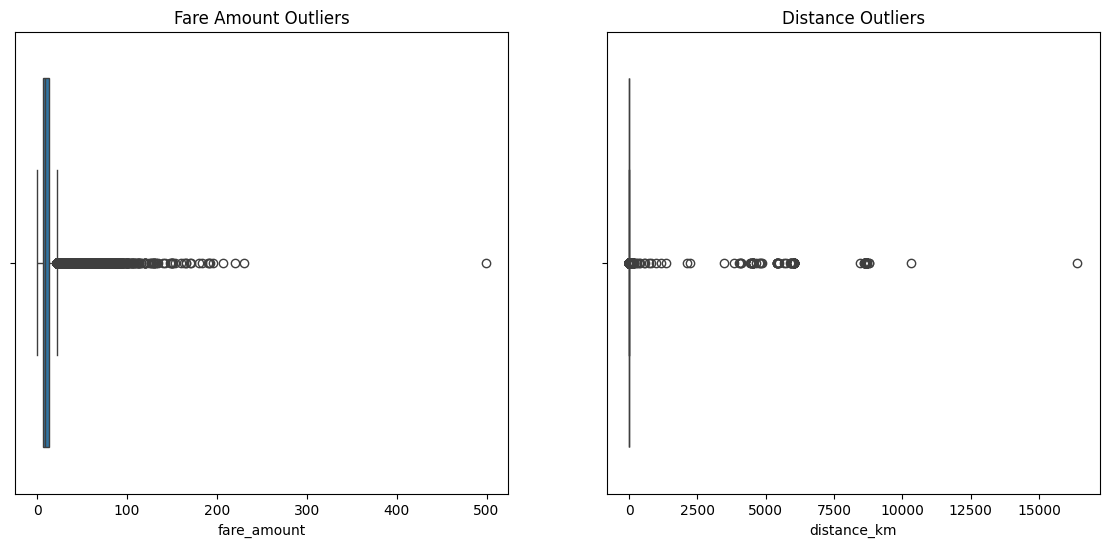

In [15]:
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
sns.boxplot(data=df, x='fare_amount')
plt.title("Fare Amount Outliers")
plt.subplot(1, 2, 2)
sns.boxplot(data=df, x='distance_km')
plt.title("Distance Outliers")
plt.show()

In [33]:
# Calculate Q1, Q3, and IQR for 'fare_amount' and 'distance_km'
Q1 = df[['fare_amount', 'distance_km']].quantile(0.25)
Q3 = df[['fare_amount', 'distance_km']].quantile(0.75)
IQR = Q3 - Q1

# Remove rows with outliers based on the IQR method
df = df[~((df[['fare_amount', 'distance_km']] < (Q1 - 1.5 * IQR)) | 
          (df[['fare_amount', 'distance_km']] > (Q3 + 1.5 * IQR))).any(axis=1)]


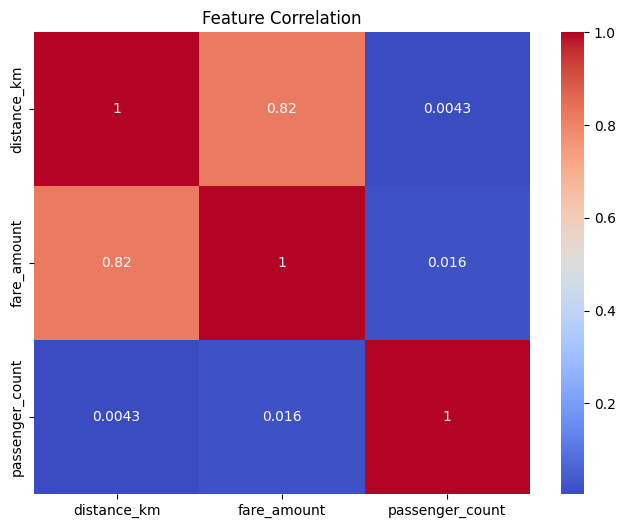

In [34]:
plt.figure(figsize=(8, 6))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm')
plt.title("Feature Correlation")
plt.show()

In [35]:
X = df[['distance_km', 'passenger_count']]
y = df['fare_amount']

In [36]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [37]:
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)
y_pred_lr = lin_reg.predict(X_test)

In [38]:
rf_reg = RandomForestRegressor(n_estimators=100, random_state=42)
rf_reg.fit(X_train, y_train)
y_pred_rf = rf_reg.predict(X_test)

In [39]:
def print_metrics(y_true, y_pred, model_name):
    r2 = r2_score(y_true, y_pred)
    rmse = root_mean_squared_error(y_true, y_pred)  # Use new function for RMSE
    mae = mean_absolute_error(y_true, y_pred)
    print(f"{model_name} Performance:")
    print(f"R-squared: {r2:.2f}")
    print(f"RMSE: {rmse:.2f}")
    print(f"MAE: {mae:.2f}\n")

In [40]:
print_metrics(y_test, y_pred_lr, "Linear Regression")

Linear Regression Performance:
R-squared: 0.67
RMSE: 2.28
MAE: 1.64



In [41]:
print_metrics(y_test, y_pred_rf, "Random Forest Regression")

Random Forest Regression Performance:
R-squared: 0.55
RMSE: 2.66
MAE: 1.92

